## 🌸 Machine Learning
### Aluna: Danielle Torres
### Colab: https://colab.research.google.com/drive/1jwCFa6wNKrYt63uokDCRgE-qeqzMnbuQ

## Classificação do dataset Iris

## Configuração do ambiente

In [3]:
#%% Ambiente e Imports

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.ensemble import (
    BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier,
    VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier
)

## Carga do Dataset

Esta célula carrega o dataset Iris, um clássico em problemas de classificação,
a partir de um arquivo CSV hospedado no GitHub. O dataset é lido usando a biblioteca pandas.

O conjunto de dados contém informações sobre flores da espécie Iris, com as seguintes variáveis:
- SepalLengthCm: comprimento da sépala em centímetros
- SepalWidthCm: largura da sépala em centímetros
- PetalLengthCm: comprimento da pétala em centímetros
- PetalWidthCm: largura da pétala em centímetros
- Species: espécie da flor, que pode ser uma das três classes:
    - Iris-setosa
    - Iris-versicolor
    - Iris-virginica 
    
Essas variáveis são atributos que serão usados para treinar e avaliar modelos de aprendizado de máquina.
Após o carregamento, são exibidas as primeiras linhas do dataset e um resumo da estrutura dos dados.

In [4]:
#%% Carga do Dataset

dataset_path = "https://raw.githubusercontent.com/DanielleTorree/ML4Iris/main/api/MachineLearning/dataset/dataset_iris.csv"
dataset = pd.read_csv(dataset_path)
dataset.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  150 non-null    float64
 1   SepalWidthCm   150 non-null    float64
 2   PetalLengthCm  150 non-null    float64
 3   PetalWidthCm   150 non-null    float64
 4   Species        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


## Separação dos Dados

Nesta etapa, o conjunto de dados é preparado para o treinamento e avaliação do modelo.

Primeiramente, são separadas as variáveis independentes (X) e a variável dependente (y):
- X corresponde às quatro características numéricas das flores.
- y corresponde à espécie da flor, que é a variável alvo.

Em seguida, os dados são divididos em dois subconjuntos:
- Conjunto de treino (80%)
- Conjunto de teste (20%)
A divisão é realizada de forma estratificada, mantendo a proporção das classes da variável alvo.

Também é definida a estratégia de validação cruzada:
- Utiliza-se o método StratifiedKFold com 10 divisões (folds)
- A validação é estratificada e embaralhada, garantindo representatividade das classes em cada partição
- A métrica escolhida para avaliação é a acurácia ("accuracy")


In [6]:
#%% Separação dos Dados

test_size = 0.20
seed = 7
X = dataset.iloc[:, 0:4].values
y = dataset.iloc[:, 4].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=seed, stratify=y
)

num_folds = 10
scoring = "accuracy"
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)

## Modelagem - Linha Base e Ensembles

Neste bloco, são definidos os modelos que serão utilizados na avaliação.

Primeiro, são criados os modelos de linha base, que servem como referência inicial de desempenho.
Esses modelos incluem:
- Regressão Logística (LR)
- K-Nearest Neighbors (KNN)
- Árvore de Decisão (CART)
- Naive Bayes (NB)
- Suporte a Vetores de Máquinas (SVM)

Em seguida, são definidos os modelos do tipo ensemble, que combinam vários algoritmos
para melhorar a precisão das previsões. Entre eles estão:
- Bagging
- Random Forest
- Extra Trees
- AdaBoost
- Gradient Boosting
- VotingClassifier (que combina Regressão Logística, Árvore de Decisão e SVM)

Todos os modelos são reunidos na lista 'all_models', que será usada na etapa de avaliação.


In [7]:
#%% Modelagem - Linha Base e Ensembles

np.random.seed(seed)

base_models = [
    ("LR", LogisticRegression(max_iter=200)),
    ("KNN", KNeighborsClassifier()),
    ("CART", DecisionTreeClassifier()),
    ("NB", GaussianNB()),
    ("SVM", SVC())
]

base_estimator = DecisionTreeClassifier()
num_trees = 100
max_features = 3

voting_models = [
    ("logistic", LogisticRegression(max_iter=200)),
    ("cart", DecisionTreeClassifier()),
    ("svm", SVC())
]

ensemble_models = [
    ("Bagging", BaggingClassifier(estimator=base_estimator, n_estimators=num_trees)),
    ("RF", RandomForestClassifier(n_estimators=num_trees, max_features=max_features)),
    ("ET", ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)),
    ("Ada", AdaBoostClassifier(n_estimators=num_trees)),
    ("GB", GradientBoostingClassifier(n_estimators=num_trees)),
    ("Voting", VotingClassifier(estimators=voting_models))
]

all_models = base_models + ensemble_models

## Avaliação dos Modelos

Nesta etapa, os modelos definidos anteriormente são avaliados.

Cada modelo é testado utilizando validação cruzada com 10 divisões (StratifiedKFold),
o que permite estimar seu desempenho de forma mais confiável.

Para cada modelo, são calculadas as médias e desvios padrão das acurácias obtidas em cada divisão.
Os resultados são armazenados para posterior comparação.

Por fim, é gerado um gráfico de boxplot que permite visualizar, de forma clara,
o desempenho de todos os modelos com base na métrica de acurácia.


LR: 0.9500 (0.0408)
KNN: 0.9250 (0.0692)
CART: 0.9333 (0.0500)
NB: 0.9417 (0.0534)
SVM: 0.9583 (0.0417)
Bagging: 0.9333 (0.0624)
RF: 0.9417 (0.0534)
ET: 0.9417 (0.0534)
Ada: 0.9333 (0.0624)
GB: 0.9417 (0.0534)
Voting: 0.9500 (0.0408)


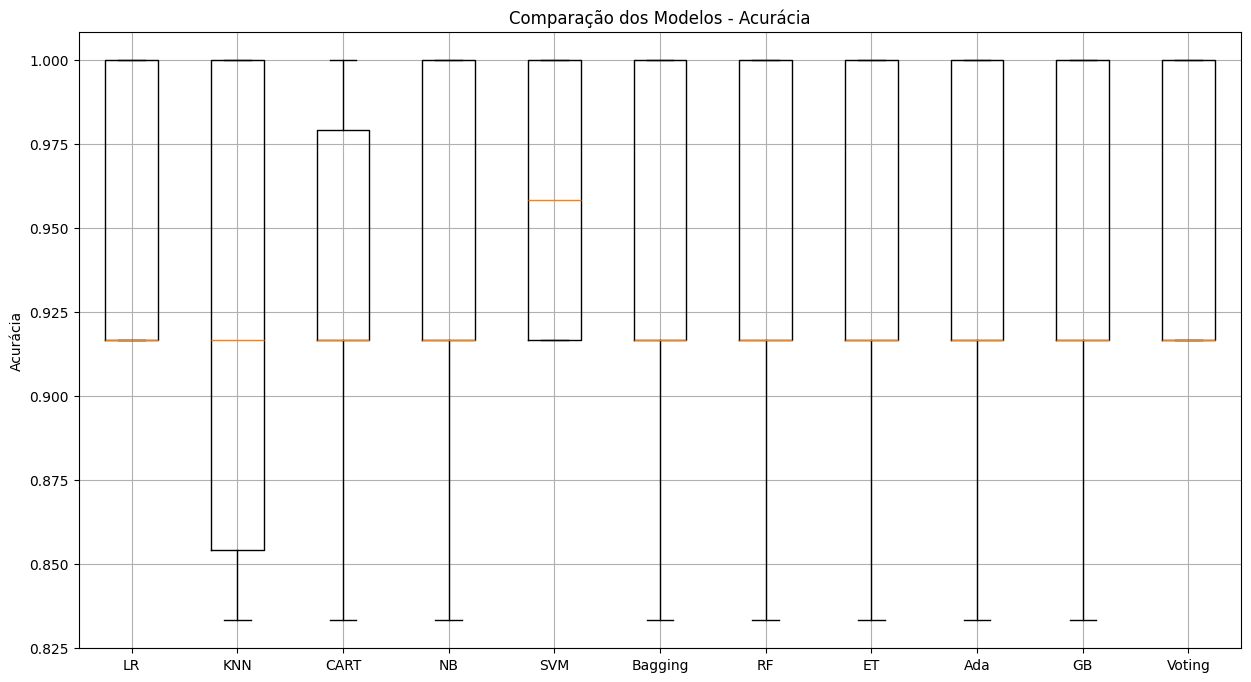

In [ ]:
#%% Avaliação dos Modelos

results = []
names = []

for name, model in all_models:
    cv_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_scores)
    names.append(name)
    print(f"{name}: {cv_scores.mean():.4f} ({cv_scores.std():.4f})")

plt.figure(figsize=(15, 8))
plt.title("Comparação dos Modelos - Acurácia")
plt.boxplot(results, labels=names)
plt.ylabel("Acurácia")
plt.grid(True)
plt.show()

## Modelagem com dados padronizados e normalizados usando Pipelines

Nesta etapa, os modelos são avaliados considerando diferentes formas de pré-processamento dos dados.

São utilizadas três versões dos dados para treinamento:
- Dados originais, sem transformação
- Dados padronizados, aplicando StandardScaler, que transforma cada valor conforme a fórmula:
 
  Fórmula: $z_i = \frac{x_i - \mu}{\sigma}$

  onde $\mu$ é a média da variável e $\sigma$ é o desvio padrão.

- Dados normalizados, aplicando MinMaxScaler, que escala os valores para o intervalo [0, 1] segundo a fórmula:

  Fórmula: $x'_i = \frac{x_i - x_{min}}{x_{max} - x_{min}}$

  onde $x_{min}$ e $x_{max}$ são os valores mínimo e máximo da variável, respectivamente.

Para facilitar o processo, são criadas pipelines que combinam o pré-processamento com cada modelo.

Cada pipeline é avaliada usando validação cruzada estratificada com 10 folds, calculando-se a acurácia média e o desvio padrão.

Os resultados são apresentados em um gráfico de boxplot para comparar o desempenho dos modelos nas três versões dos dados.


LR-orig: 0.9500 (0.0408)
LR-std: 0.9417 (0.0534)
LR-minmax: 0.9250 (0.0786)
KNN-orig: 0.9250 (0.0692)
KNN-std: 0.9417 (0.0651)
KNN-minmax: 0.9583 (0.0559)
CART-orig: 0.9333 (0.0500)
CART-std: 0.9417 (0.0534)
CART-minmax: 0.9417 (0.0534)
NB-orig: 0.9417 (0.0534)
NB-std: 0.9417 (0.0534)
NB-minmax: 0.9417 (0.0534)
SVM-orig: 0.9583 (0.0417)
SVM-std: 0.9417 (0.0534)
SVM-minmax: 0.9500 (0.0408)
Bagging-orig: 0.9417 (0.0534)
Bagging-std: 0.9417 (0.0534)
Bagging-minmax: 0.9417 (0.0534)
RF-orig: 0.9333 (0.0624)
RF-std: 0.9417 (0.0534)
RF-minmax: 0.9417 (0.0534)
ET-orig: 0.9333 (0.0624)
ET-std: 0.9417 (0.0534)
ET-minmax: 0.9333 (0.0624)
Ada-orig: 0.9333 (0.0624)
Ada-std: 0.9333 (0.0624)
Ada-minmax: 0.9333 (0.0624)
GB-orig: 0.9417 (0.0534)
GB-std: 0.9417 (0.0534)
GB-minmax: 0.9417 (0.0534)
Voting-orig: 0.9500 (0.0408)
Voting-std: 0.9417 (0.0534)
Voting-minmax: 0.9417 (0.0534)


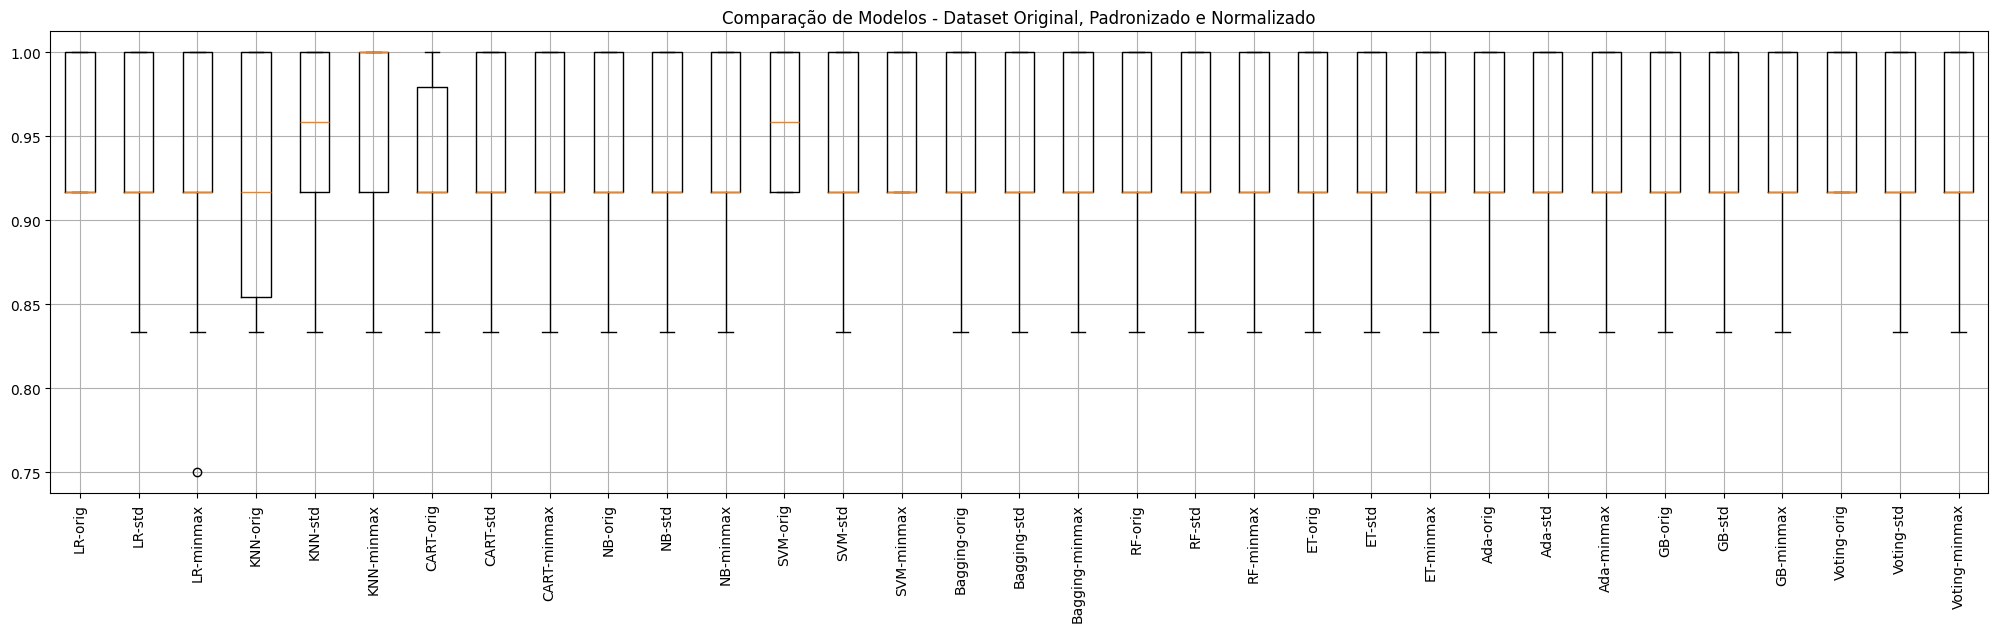

In [8]:
#%% Modelagem com dados padronizados e normalizados usando Pipelines

standard_scaler = ("StandardScaler", StandardScaler())
minmax_scaler = ("MinMaxScaler", MinMaxScaler())

pipelines = []

for name, model in all_models: 
    pipelines.append((f"{name}-orig", Pipeline(steps=[(name, model)])))
    pipelines.append((f"{name}-std", Pipeline(steps=[standard_scaler, (name, model)])))
    pipelines.append((f"{name}-minmax", Pipeline(steps=[minmax_scaler, (name, model)])))

results = [] 
names = []

for name, pipeline in pipelines:
    cv_results = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f"{name}: {cv_results.mean():.4f} ({cv_results.std():.4f})")

plt.figure(figsize=(25, 6))
plt.title("Comparação de Modelos - Dataset Original, Padronizado e Normalizado")
plt.boxplot(results, labels=names)
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

## Otimização de hiperparâmetros com Grid Search

Nesta etapa, é realizada a otimização dos hiperparâmetros de alguns modelos selecionados.

Define-se um conjunto de parâmetros (param_grid) para os modelos:
- Regressão Logística (LR)
- K-Nearest Neighbors (KNN)
- Random Forest (RF)

Para cada modelo e seu respectivo pipeline, é aplicado o Grid Search com validação cruzada de 5 folds,
buscando a combinação de parâmetros que maximiza a acurácia.

Ao final, é exibida a melhor pontuação obtida e os parâmetros correspondentes para cada modelo otimizado.


In [ ]:
#%% Otimização de hiperparâmetros com Grid Search

param_grids = {
    "LR": {
        "LR__C": [0.5, 1, 2],
        "LR__solver": ["saga"],
    },
    "KNN": {
        "KNN__n_neighbors": [9, 11, 13],
        "KNN__metric": ["euclidean"],
    },
    "RF": {
        "RF__n_estimators": [5, 10, 20],
        "RF__max_features": ["sqrt"],
        "RF__max_depth": [None, 10],
        "RF__min_samples_split": [2, 5],
        "RF__min_samples_leaf": [1, 2],
    }
}

grid_models = ["LR", "KNN", "RF"]
kfold_gs = 5

for name, pipeline in pipelines:
    model_key = name.split("-")[0]
    if model_key in grid_models:
        param_grid = param_grids[model_key]
        grid = GridSearchCV(pipeline, param_grid=param_grid, scoring=scoring, cv=kfold_gs, n_jobs=-1)
        grid.fit(X_train, y_train)
        print(f"Modelo: {name} - Melhor: {grid.best_score_:.4f} usando {grid.best_params_}")

Modelo: LR-orig - Melhor: 0.9833 usando {'LR__C': 0.5, 'LR__solver': 'saga'}
Modelo: LR-std - Melhor: 0.9500 usando {'LR__C': 0.5, 'LR__solver': 'saga'}
Modelo: LR-minmax - Melhor: 0.9417 usando {'LR__C': 2, 'LR__solver': 'saga'}
Modelo: KNN-orig - Melhor: 0.9750 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 11}
Modelo: KNN-std - Melhor: 0.9583 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 9}
Modelo: KNN-minmax - Melhor: 0.9500 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 9}
Modelo: RF-orig - Melhor: 0.9500 usando {'RF__max_depth': None, 'RF__max_features': 'sqrt', 'RF__min_samples_leaf': 2, 'RF__min_samples_split': 2, 'RF__n_estimators': 5}
Modelo: RF-std - Melhor: 0.9583 usando {'RF__max_depth': None, 'RF__max_features': 'sqrt', 'RF__min_samples_leaf': 1, 'RF__min_samples_split': 5, 'RF__n_estimators': 5}
Modelo: RF-minmax - Melhor: 0.9667 usando {'RF__max_depth': None, 'RF__max_features': 'sqrt', 'RF__min_samples_leaf': 2, 'RF__min_samples_split': 2, '

In [9]:
# Modelo: LR-orig - Melhor: 0.9833 usando {'LR__C': 0.5, 'LR__solver': 'saga'}
# Modelo: LR-std - Melhor: 0.9500 usando {'LR__C': 0.5, 'LR__solver': 'saga'}
# Modelo: LR-minmax - Melhor: 0.9417 usando {'LR__C': 2, 'LR__solver': 'saga'}
# Modelo: KNN-orig - Melhor: 0.9750 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 11}
# Modelo: KNN-std - Melhor: 0.9583 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 9}
# Modelo: KNN-minmax - Melhor: 0.9500 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 9}
# Modelo: RF-orig - Melhor: 0.9500 usando {'RF__max_depth': None, 'RF__max_features': 'sqrt', 'RF__min_samples_leaf': 2, 'RF__min_samples_split': 2, 'RF__n_estimators': 5}
# Modelo: RF-std - Melhor: 0.9583 usando {'RF__max_depth': None, 'RF__max_features': 'sqrt', 'RF__min_samples_leaf': 1, 'RF__min_samples_split': 5, 'RF__n_estimators': 5}
# Modelo: RF-minmax - Melhor: 0.9667 usando {'RF__max_depth': None, 'RF__max_features': 'sqrt', 'RF__min_samples_leaf': 2, 'RF__min_samples_split': 2, 'RF__n_estimators': 20}

## Treinamento final e avaliação no conjunto teste

Nesta etapa, o modelo final escolhido, uma Random Forest com parâmetros específicos,
é treinado usando o conjunto de dados de treinamento.

O pipeline inclui a normalização dos dados com MinMaxScaler antes do treinamento.

Após o treinamento, o modelo é testado no conjunto de teste separado anteriormente,
e a acurácia obtida é exibida para avaliar o desempenho do modelo na generalização.


In [10]:
#%% Treinamento final e avaliação no conjunto teste

final_model = RandomForestClassifier(
    n_estimators=50,
    max_features="sqrt",
    min_samples_split=2,
    max_depth=10,
    min_samples_leaf=1,
)

pipeline_final = make_pipeline(MinMaxScaler(), final_model)
pipeline_final.fit(X_train, y_train)

y_pred = pipeline_final.predict(X_test)
print(f"Acurácia no conjunto teste: {accuracy_score(y_test, y_pred):.4f}")

Acurácia no conjunto teste: 1.0000


## Salvando modelo e scaler

Nesta etapa, são criadas pastas para armazenar os arquivos gerados durante o processo,
garantindo que os diretórios existam.

Em seguida, são salvos em disco:
- O modelo final treinado (Random Forest) no arquivo "rf_iris_classifier.pkl"
- O objeto do scaler utilizado (MinMaxScaler) no arquivo "minmax_scaler_iris.pkl"
- A pipeline completa, que inclui o pré-processamento e o modelo, no arquivo "rf_iris_pipeline.pkl"

Também são salvos em CSV os dados de teste (X_test e y_test), para possível uso futuro ou validação externa.


In [11]:
#%% Salvando modelo e scaler

import os

os.makedirs("../models", exist_ok=True)
os.makedirs("../scalers", exist_ok=True)
os.makedirs("../pipelines", exist_ok=True)
os.makedirs("../data", exist_ok=True)

with open("../models/rf_iris_classifier.pkl", "wb") as f:
    pickle.dump(final_model, f)

with open("../scalers/minmax_scaler_iris.pkl", "wb") as f:
    pickle.dump(pipeline_final.named_steps["minmaxscaler"], f)

with open("../pipelines/rf_iris_pipeline.pkl", "wb") as f:
    pickle.dump(pipeline_final, f)

pd.DataFrame(X_test, columns=dataset.columns[:-1]).to_csv("../data/X_test_iris.csv", index=False)
pd.DataFrame(y_test, columns=[dataset.columns[-1]]).to_csv("../data/y_test_iris.csv", index=False)

## Simulação de predição em dados novos

Nesta etapa, são criados novos dados com as mesmas características do dataset original.

Os dados são convertidos para o formato numérico e passam pelo mesmo processo de normalização
utilizado no treinamento, garantindo que as escalas sejam compatíveis.

Em seguida, o modelo final treinado realiza as previsões da espécie da flor para esses novos exemplos.

Por fim, as previsões são exibidas no console.


In [12]:
#%% Simulação de predição em dados novos

new_data = pd.DataFrame({
    "SepalLengthCm": [5.1, 6.2, 5.9, 4.7],
    "SepalWidthCm": [3.5, 2.8, 3.0, 3.2],
    "PetalLengthCm": [1.4, 4.8, 4.2, 1.3],
    "PetalWidthCm": [0.2, 1.8, 1.3, 0.2]
})

X_new = new_data.values.astype(float)
X_new_scaled = pipeline_final.named_steps["minmaxscaler"].transform(X_new)
predictions = final_model.predict(X_new_scaled)
print("Previsões para novos dados:", predictions)

Previsões para novos dados: ['Iris-setosa' 'Iris-virginica' 'Iris-versicolor' 'Iris-setosa']
